In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import statsmodels.formula.api as sm
import scipy.stats as stats
import statsmodels.api as smm
import sklearn.linear_model
import scipy, scipy.stats
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
from pandas import DataFrame, Series

In [2]:
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        if (filename == "public_use-talent-migration.xlsx"):
          print(os.path.join(dirname, filename))

try:
  data = pd.read_excel("public_use-talent-migration.xlsx", sheet_name="Skill Migration")
except:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data = pd.read_excel("/content/gdrive/MyDrive/Statistics Group Assignment/public_use-talent-migration.xlsx", sheet_name="Skill Migration")

data.head()

Mounted at /content/gdrive


,country_code,country_name,wb_income,wb_region,skill_group_id,skill_group_category,skill_group_name,net_per_10K_2015,net_per_10K_2016,net_per_10K_2017,net_per_10K_2018,net_per_10K_2019
0,ar,Argentina,High income,Latin America & Caribbean,1885,Business Skills,Affiliate Marketing,-134.97,-28.22,30.55,-83.54,-323.41
1,ar,Argentina,High income,Latin America & Caribbean,599,Business Skills,Sales Leads,-247.56,-157.47,-18.57,-117.29,-248.57
2,ar,Argentina,High income,Latin America & Caribbean,2776,Business Skills,Revenue Analysis,-87.48,-142.38,-115.12,-92.47,-233.48
3,af,Afghanistan,Low income,South Asia,20157,Disruptive Tech Skills,Aerospace Engineering,-1191.93,-935.16,-605.60,54.71,-459.57
4,af,Afghanistan,Low income,South Asia,1871,Specialized Industry Skills,Air Force,-1488.62,-839.32,-777.83,-480.36,-553.91


In [3]:
# printing dataframes can get split across lines if the width is too big. Increase this setting to avoid splitting the tables.
pd.set_option('display.width', 150)

BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

def bold(input):
  return BOLD+input+END
def underline(input):
  return UNDERLINE+input+END

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17617 entries, 0 to 17616
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_code          17617 non-null  object 
 1   country_name          17617 non-null  object 
 2   wb_income             17617 non-null  object 
 3   wb_region             17617 non-null  object 
 4   skill_group_id        17617 non-null  int64  
 5   skill_group_category  17617 non-null  object 
 6   skill_group_name      17617 non-null  object 
 7   net_per_10K_2015      17617 non-null  float64
 8   net_per_10K_2016      17617 non-null  float64
 9   net_per_10K_2017      17617 non-null  float64
 10  net_per_10K_2018      17617 non-null  float64
 11  net_per_10K_2019      17617 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 1.6+ MB


In [4]:
print(f'{bold(underline("Income"))}\n',data['wb_income'].value_counts().index.tolist())
print(f'{bold(underline("Region"))}\n',data['wb_region'].value_counts().index.tolist())
print(f'{bold(underline("Skill Groups"))}\n',data['skill_group_category'].value_counts().index.tolist())


Income
 ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
Region
 ['Europe & Central Asia', 'East Asia & Pacific', 'Middle East & North Africa', 'Latin America & Caribbean ', 'Sub-Saharan Africa ', 'South Asia', 'North America']
Skill Groups
 ['Specialized Industry Skills', 'Business Skills', 'Tech Skills', 'Soft Skills', 'Disruptive Tech Skills']


In [5]:
# Need to keep 'skill_group_name' column to avoid duplicate rows
df_filtered = data.drop(columns=['country_code', 'skill_group_id', 'net_per_10K_2015', 'net_per_10K_2016', 'net_per_10K_2017', 'net_per_10K_2018'])
df_filtered = df_filtered.rename(columns={
    "country_name": "country",
    "wb_income": "income",
    "wb_region": "region",
    "skill_group_category": "skill_group",
    "skill_group_name": "skill_name",
    "net_per_10K_2019": 'net_per_10k'
    })
string_cols = ["country", "income", "region", "skill_group", "skill_name"]
df_filtered['income'] = df_filtered['income'].apply(lambda x: x.title())
df_filtered[string_cols] = df_filtered[string_cols].apply(lambda x: x.astype("string"))

print()
print(df_filtered.info(),'\n')
print(f'{bold(underline("Non-Null Summary"))}')
print(df_filtered.isnull().sum(),'\n')
print(f'{bold(underline("Row Duplication Summary"))}')
print(df_filtered.duplicated().sum(),'\n')
print(f'\t\t\t\t\t{bold(underline("Filtered Data"))}')
df_filtered.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17617 entries, 0 to 17616
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      17617 non-null  string 
 1   income       17617 non-null  string 
 2   region       17617 non-null  string 
 3   skill_group  17617 non-null  string 
 4   skill_name   17617 non-null  string 
 5   net_per_10k  17617 non-null  float64
dtypes: float64(1), string(5)
memory usage: 825.9 KB
None 

Non-Null Summary
country        0
income         0
region         0
skill_group    0
skill_name     0
net_per_10k    0
dtype: int64 

Row Duplication Summary
0 

					Filtered Data


,country,income,region,skill_group,skill_name,net_per_10k
0,Argentina,High Income,Latin America & Caribbean,Business Skills,Affiliate Marketing,-323.41
1,Argentina,High Income,Latin America & Caribbean,Business Skills,Sales Leads,-248.57
2,Argentina,High Income,Latin America & Caribbean,Business Skills,Revenue Analysis,-233.48
3,Afghanistan,Low Income,South Asia,Disruptive Tech Skills,Aerospace Engineering,-459.57
4,Afghanistan,Low Income,South Asia,Specialized Industry Skills,Air Force,-553.91


In [6]:
df_filtered.dtypes

country        string[python]
income         string[python]
region         string[python]
skill_group    string[python]
skill_name     string[python]
net_per_10k           float64
dtype: object

In [7]:
# Separate the whole dataframe based on income level and skill group
skills_dict = {
  'ts':  'Tech Skills',
  'bs':  'Business Skills',
  'ss':  'Soft Skills',
  'sis': 'Specialized Industry Skills',
  'dts': 'Disruptive Tech Skills',
  'all': None
}
income_dict = {
    'hi':  'High Income',
    'umi': 'Upper Middle Income',
    'lmi': 'Lower Middle Income',
    'li':  'Low Income'
}

hi_df = {}
umi_df = {}
lmi_df = {}
li_df = {}

# Creates dictionaries of dataframes based on the income level and skill group
for income_key, income_value in income_dict.items():
  for skill_key, skill_value in skills_dict.items():
    if skill_value != None:
      locals()[f'{income_key}_df'][skill_key] = df_filtered[(df_filtered['income'] == income_value) & (df_filtered['skill_group'] == skill_value)]
    else:
      locals()[f'{income_key}_df'][skill_key] = df_filtered[df_filtered['income'] == income_value]

for key, df in hi_df.items():
  print(df.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
Index: 925 entries, 373 to 17012
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      925 non-null    string 
 1   income       925 non-null    string 
 2   region       925 non-null    string 
 3   skill_group  925 non-null    string 
 4   skill_name   925 non-null    string 
 5   net_per_10k  925 non-null    float64
dtypes: float64(1), string(5)
memory usage: 50.6 KB
None 

<class 'pandas.core.frame.DataFrame'>
Index: 1837 entries, 0 to 7900
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      1837 non-null   string 
 1   income       1837 non-null   string 
 2   region       1837 non-null   string 
 3   skill_group  1837 non-null   string 
 4   skill_name   1837 non-null   string 
 5   net_per_10k  1837 non-null   float64
dtypes: float64(1), string(5)
memory usage: 100.5 KB
None 

<clas

In [8]:
# Example on how to access a skill group in an income level dictionary
# High Income, Disruptive Tech Skills
hi_df['dts'].head(3)

,country,income,region,skill_group,skill_name,net_per_10k
369,Argentina,High Income,Latin America & Caribbean,Disruptive Tech Skills,Artificial Intelligence (AI),-227.95
375,Argentina,High Income,Latin America & Caribbean,Disruptive Tech Skills,Human Computer Interaction,-196.16
384,Argentina,High Income,Latin America & Caribbean,Disruptive Tech Skills,Aerospace Engineering,-175.88


<Axes: ylabel='Frequency'>

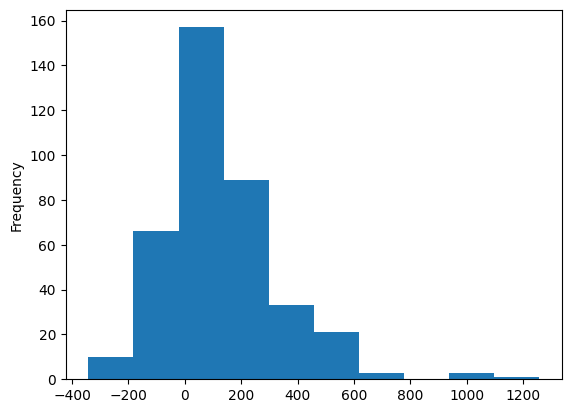

In [9]:
hi_df['dts']['net_per_10k'].plot(kind='hist')


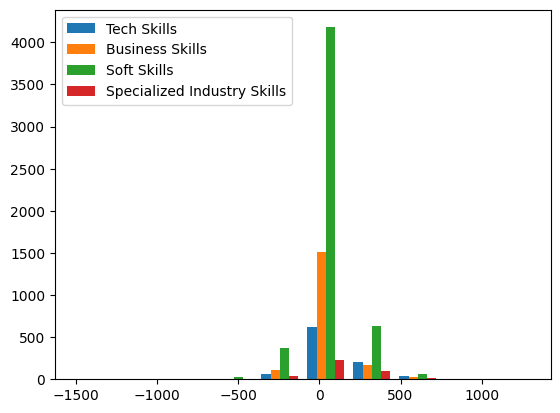

In [10]:
plt.hist([hi_df['ts']['net_per_10k'], hi_df['bs']['net_per_10k'], hi_df['sis']['net_per_10k'], hi_df['dts']['net_per_10k']], label=list(skills_dict.values()))
plt.legend(prop={'size': 10})

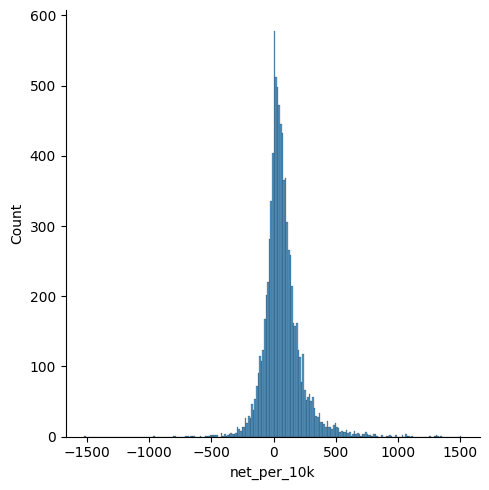

In [11]:
sb.displot(data=hi_df['all'], x="net_per_10k")

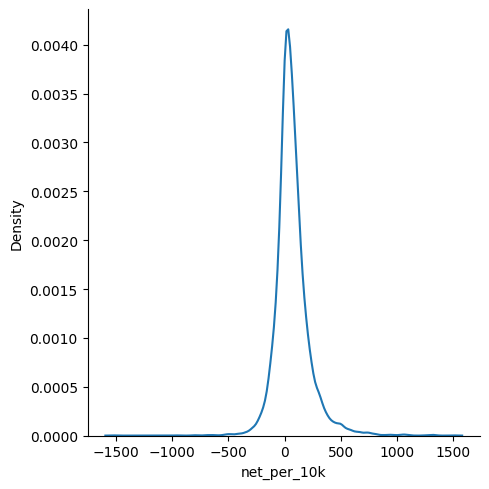

In [12]:
sb.displot(data=hi_df['all'], x="net_per_10k", kind='kde')

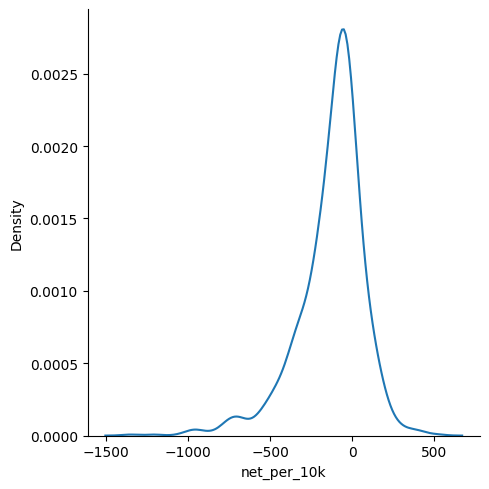

In [13]:
sb.displot(data=li_df['all'], x="net_per_10k", kind='kde')

Text(0.5, 1.0, 'QQ Plot - Soft Skills')

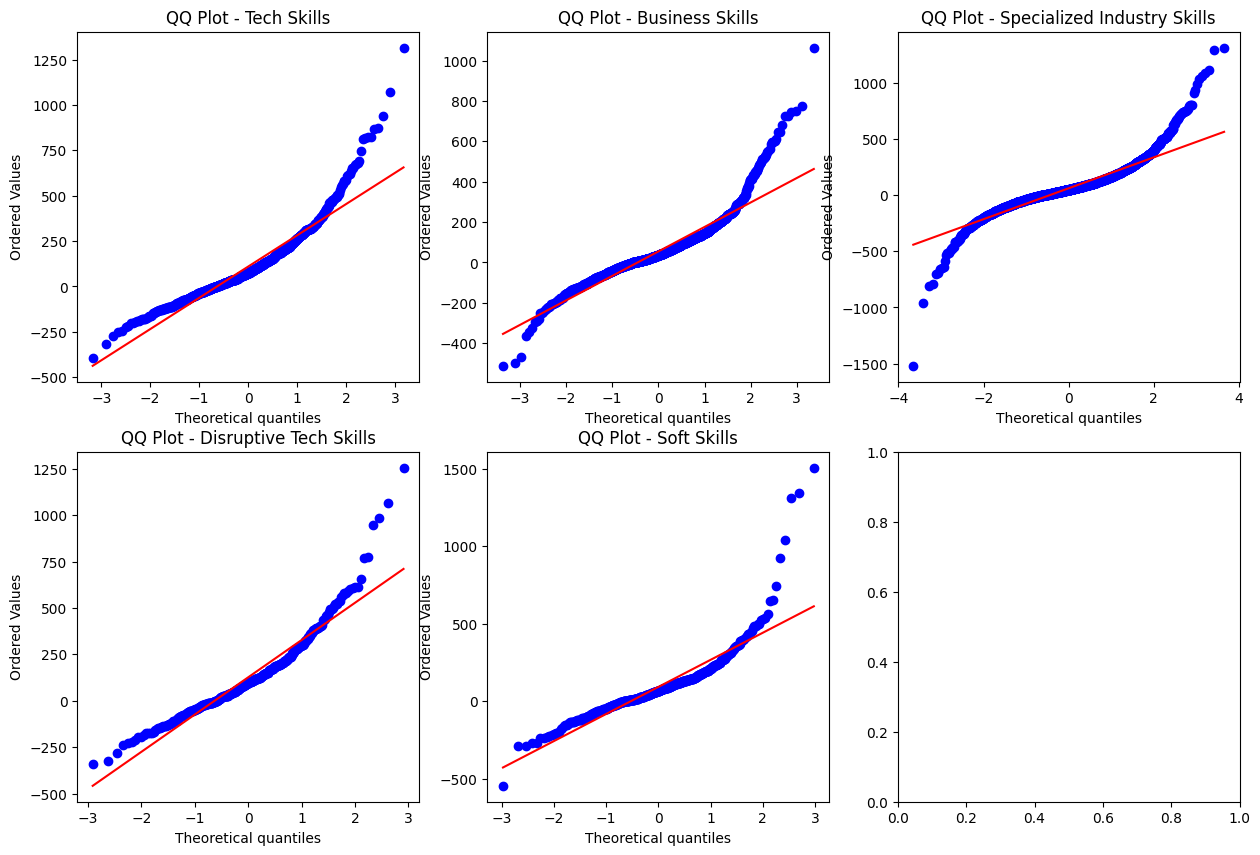

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

stats.probplot(hi_df['ts']['net_per_10k'], dist="norm", plot=axs[0,0])
axs[0,0].set_title('QQ Plot - Tech Skills')

stats.probplot(hi_df['bs']['net_per_10k'], dist="norm", plot=axs[0,1])
axs[0,1].set_title('QQ Plot - Business Skills')

stats.probplot(hi_df['sis']['net_per_10k'], dist="norm", plot=axs[0,2])
axs[0,2].set_title('QQ Plot - Specialized Industry Skills')

stats.probplot(hi_df['dts']['net_per_10k'], dist="norm", plot=axs[1,0])
axs[1,0].set_title('QQ Plot - Disruptive Tech Skills')

stats.probplot(hi_df['ss']['net_per_10k'], dist="norm", plot=axs[1,1])
axs[1,1].set_title('QQ Plot - Soft Skills')

#sis data is over-dispersed. Over-dispersed data has an increased number of outliers (i.e. the distribution has fatter tails than a normal distribution).
#Over-dispersed data is also known as having a leptokurtic distribution and as having positive excess kurtosis.
#the smallest observations are smaller than you would expect from a normal distribution (i.e. the points are below the line on the QQ-plot). This means the lower tail of the data’s distribution has been extended, relative to a normal distribution.
#the largest observations are larger than you would expect from a normal distribution (i.e. the points are above the line on the QQ-plot). This means the upper tail of the data’s distribution has been extended, relative to a normal distribution.

In [15]:
# Null hypothesis: population means are equal
# Alternative hypothesis: at least 2 of the population means are no equal
df['skill_group'] = df['skill_group'].astype('category')

# Fitting the ANOVA model
model = sm.ols('net_per_10k ~ skill_group', data=df).fit()

# Print ANOVA table
print(smm.stats.anova_lm(model))

#The p-value tells us whether there is a significant difference in the mean values between the three groups. Since p-value is <0.05, 2 or more groups have significantly different means
#This suggests that the mean of net_per_10k differs across the levels of the skill_group variable. This conclusion is supported by the statistically significant F-statistic and the associated very small p-value (6.49e-34), indicating that the effect of skill_group on net_per_10k is unlikely to be due to random chance.

                 df        sum_sq        mean_sq          F        PR(>F)
skill_group     4.0  3.812479e+06  953119.633164  40.775693  6.490410e-34
Residual     8899.0  2.080115e+08   23374.701076        NaN           NaN


<ipython-input-15-8e883801dafa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skill_group'] = df['skill_group'].astype('category')


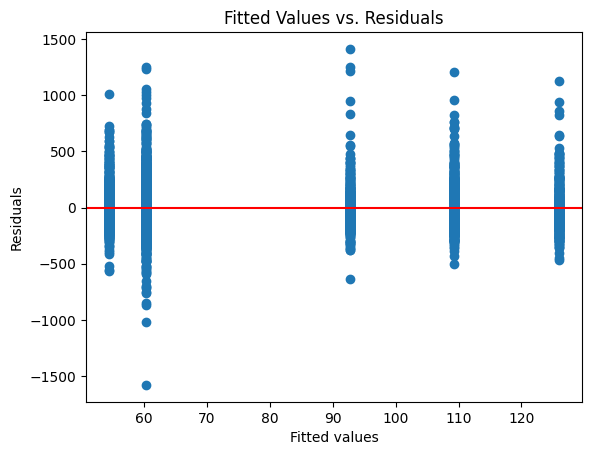

In [16]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Fitted Values vs. Residuals')
plt.axhline(y=0, color='r', linestyle='-')

# Since the spread of residuals are consistent across different fitted values (no patterns), there is likely variance homogeneity
# ANOVA has an assumpation that observations within groups are independent.

In [17]:
# ANOVA (F ratio)
#ref: https://www.youtube.com/watch?v=-yQb_ZJnFXw
# Total Sum of Squares (SST) = Sum of Squares Between Groups (SSB) + Sum of Squares Within Groups (SSW)
# Let Part A be "Total Sum of Squares"
# Let Part B be "Sum of Squares Between Groups"
# Let Part C be "Sum of Squares Within Groups"

# count(n)
# sum
# mean
# formula: (x-mean)**2

#list_of_(xx_df) # xx is abrviation of income level
#for i in range(len(list_of_(xx_df))):

#list_of_(xx_df) = [hi_df, umi_df, lmi_df, li_df]


# (Part C) Sum of Squares Within Groups (SSW)
print("\nMeans of different income levels of different skillsets\n")

print("mean(hi,ts):", hi_df['ts']['net_per_10k'].mean())
print("mean(hi,bs):", hi_df['bs']['net_per_10k'].mean())
print("mean(hi,ss):", hi_df['ss']['net_per_10k'].mean())
print("mean(hi,sis):", hi_df['sis']['net_per_10k'].mean())
print("mean(hi,dts):", hi_df['dts']['net_per_10k'].mean())
print("mean(hi,all):", hi_df['all']['net_per_10k'].mean())
print("")

print("mean(umi,ts):", umi_df['ts']['net_per_10k'].mean())
print("mean(umi,bs):", umi_df['bs']['net_per_10k'].mean())
print("mean(umi,ss):", umi_df['ss']['net_per_10k'].mean())
print("mean(umi,sis):", umi_df['sis']['net_per_10k'].mean())
print("mean(umi,dts):", umi_df['dts']['net_per_10k'].mean())
print("mean(umi,all):", umi_df['all']['net_per_10k'].mean())
print("")

print("mean(lmi,ts):", lmi_df['ts']['net_per_10k'].mean())
print("mean(lmi,bs):", lmi_df['bs']['net_per_10k'].mean())
print("mean(lmi,ss):", lmi_df['ss']['net_per_10k'].mean())
print("mean(lmi,sis):", lmi_df['sis']['net_per_10k'].mean())
print("mean(lmi,dts):", lmi_df['dts']['net_per_10k'].mean())
print("mean(lmi,all):", lmi_df['all']['net_per_10k'].mean())
print("")

print("mean(li,ts):", li_df['ts']['net_per_10k'].mean())
print("mean(li,bs):", li_df['bs']['net_per_10k'].mean())
print("mean(li,ss):", li_df['ss']['net_per_10k'].mean())
print("mean(li,sis):", li_df['sis']['net_per_10k'].mean())
print("mean(li,dts):", li_df['dts']['net_per_10k'].mean())
print("mean(li,all):", li_df['all']['net_per_10k'].mean())
print("")



Means of different income levels of different skillsets

mean(hi,ts): 109.23810810810811
mean(hi,bs): 54.33198693522048
mean(hi,ss): 92.73364779874215
mean(hi,sis): 60.24553199545627
mean(hi,dts): 126.05903394255874
mean(hi,all): 68.68649707996406

mean(umi,ts): -200.52567877629062
mean(umi,bs): -137.4935322425409
mean(umi,ss): -182.23989399293285
mean(umi,sis): -155.8174175347222
mean(umi,dts): -231.78768817204298
mean(umi,all): -161.80402306805072

mean(lmi,ts): -162.24180904522615
mean(lmi,bs): -95.81343638525566
mean(lmi,ss): -117.1255909090909
mean(lmi,sis): -105.90886930091185
mean(lmi,dts): -231.38698529411764
mean(lmi,all): -116.2369413580247

mean(li,ts): -201.67512820512817
mean(li,bs): -101.41756232686983
mean(li,ss): -112.39831683168316
mean(li,sis): -120.3149896049896
mean(li,dts): -231.32615384615383
mean(li,all): -128.57514938488578



In [18]:
# x - mean
#buss_hi_df[2015] - meanList2015[0]

# (x-mean)**2
#np.square( buss_hi_df[2015] - meanList2015[0])

# sum the whole column of buss skill in 2015
#np.sum(np.square( buss_hi_df[2015] - meanList2015[0]))

#sqList_ts = []
#sqList_bs = []
#sqList_ss = []
#sqList_sis = []
#sqList_dts = []


#for i in range(len(skillList)):


# (Part C)
# Calculation: Sum of Squares Within Groups: Step2, to obtain "x - mean" of each skill from high income
sumOfDiff_ts = np.sum(np.square(hi_df['ts']['net_per_10k'] - hi_df['ts']['net_per_10k'].mean()))
sumOfDiff_bs = np.sum(np.square(hi_df['bs']['net_per_10k'] - hi_df['bs']['net_per_10k'].mean()))
sumOfDiff_ss = np.sum(np.square(hi_df['ss']['net_per_10k'] - hi_df['ss']['net_per_10k'].mean()))
sumOfDiff_sis= np.sum(np.square(hi_df['sis']['net_per_10k'] - hi_df['sis']['net_per_10k'].mean()))
sumOfDiff_dts= np.sum(np.square(hi_df['dts']['net_per_10k'] - hi_df['dts']['net_per_10k'].mean()))
print("sum of (x-mean) of skills:")
print("tech skill:", sumOfDiff_ts)
print("buss skill:", sumOfDiff_bs)
print("soft skill:", sumOfDiff_ss)
print("spec skill:", sumOfDiff_sis)
print("dtec skill:", sumOfDiff_dts)
print("")

# Calculation: Sum of Squares Within Groups: Step3, to obtain "square of (x - mean)" of each skill from high income
print("sum of square of (x-mean) of skills:")
print("sum of (x-mean)^2, tech skill:", sumOfDiff_ts)
print("sum of (x-mean)^2, buss skill:", sumOfDiff_bs)
print("sum of (x-mean)^2, soft skill:", sumOfDiff_ss)
print("sum of (x-mean)^2, spec skill:", sumOfDiff_sis)
print("sum of (x-mean)^2, dtec skill:", sumOfDiff_dts)
print ("")

ssw = (sumOfDiff_ts) + (sumOfDiff_bs) + (sumOfDiff_ss) + (sumOfDiff_sis) + (sumOfDiff_dts)
print("Sum of Squares Within Groups (SSW):", ssw)
print("")

sum of (x-mean) of skills:
tech skill: 30139742.138389193
buss skill: 30257802.566047687
soft skill: 17746195.85165283
spec skill: 113194718.0885551
dtec skill: 16673006.22834256

sum of square of (x-mean) of skills:
sum of (x-mean)^2, tech skill: 30139742.138389193
sum of (x-mean)^2, buss skill: 30257802.566047687
sum of (x-mean)^2, soft skill: 17746195.85165283
sum of (x-mean)^2, spec skill: 113194718.0885551
sum of (x-mean)^2, dtec skill: 16673006.22834256

Sum of Squares Within Groups (SSW): 208011464.87298736



In [19]:
# (Part A) Total Sum of Squares (SST)

sst = np.sum(np.square(hi_df['all']['net_per_10k'] - hi_df['all']['net_per_10k'].mean()))
#print("sum of (x-mean) of all skills")
#print("all skill:", sumOfDiff_all)
#print("")


# Calculation: Sum of Squares of all Groups: to obtain "square of (x - mean)" of ALL skills from high income
#sst = (sumOfDiff_all)**2
print("Total Sum of Square of (x-mean) of all skills (SST):", sst)
print("")

Total Sum of Square of (x-mean) of all skills (SST): 211823943.4056439



In [20]:
# (Part B) Sum of Squares Between Groups (SSB)

#sst = ssb - ssw
#ssb = sst - ssw
ssb = sst - ssw
print(sst)
print(ssb)
print(ssw)

211823943.4056439
3812478.5326565504
208011464.87298736


In [21]:
print(len(hi_df['all']['net_per_10k']))

8904


numGroups: 5
degreeOfFreedom_SSB_numerator: 4
x: 953119.6331641376

numObservations: 8904
numGroups: 5
degreeOfFreedom_SSW_denominator: 8899
y: 23374.701075737426

F-score ( 4 , 8899 ) = 40.77569292013154 , p<.05

The F critical value is approximately 2.3729


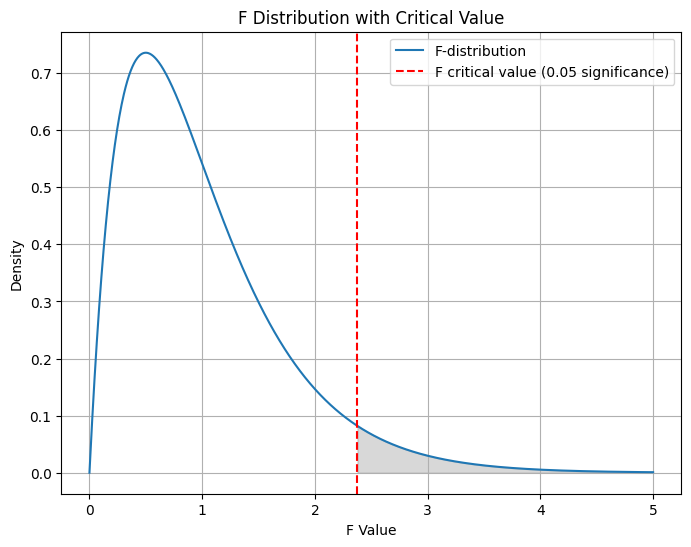

In [22]:
from scipy.stats import f

#degreeOfFreedom_SSB  = SSB / degree of Freedom
#                     = SSB/ (#Groups - 1)
numGroups = len(np.unique(df_filtered['skill_group']))
degreeOfFreedom_SSB =  numGroups - 1
x = ssb/degreeOfFreedom_SSB
print( "numGroups:", numGroups)
print("degreeOfFreedom_SSB_numerator:", degreeOfFreedom_SSB)
print("x:", x)
print("")

#degreeOfFreedom_SSW  = SSW / degree of Freedom
#                     = SSW/ (#observations - #Groups)
numObservations = (len(hi_df['all']['net_per_10k']))
numGroups = len(np.unique(df_filtered['skill_group']))
degreeOfFreedom_SSW =  numObservations - numGroups
y = ssw/degreeOfFreedom_SSW
print( "numObservations:", numObservations)
print( "numGroups:", numGroups)
print ("degreeOfFreedom_SSW_denominator:", degreeOfFreedom_SSW)
print ("y:", y)
print ("")

#my calculated F score = (ssb/degOfFreedom ) / (ssw/degreeOfFreedom)
f_score = x/y
print ("F-score (", degreeOfFreedom_SSB, ",", degreeOfFreedom_SSW, ") =", f_score,", p<.05")
print ("")

#functional call of F score
alpha = 0.05
dfn = degreeOfFreedom_SSB
dfd = degreeOfFreedom_SSW
f_critical = scipy.stats.f.ppf(q=1 - alpha, dfn=dfn, dfd=dfd)
print(f"The F critical value is approximately {f_critical:.4f}")

# Generate F values for the x-axis
x = np.linspace(0, 5, 1000)
#x = np.linspace(f.ppf(0.01, dfn, dfd), f.ppf(0.99, dfn, dfd), 100)
f_values = scipy.stats.f.pdf(x, dfn, dfd)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, f_values, label="F-distribution")
plt.axvline(f_critical, color='r', linestyle='--', label=f"F critical value ({alpha:.2f} significance)")
plt.fill_between(x, f_values, where=(x >= f_critical), color='gray', alpha=0.3)
plt.xlabel("F Value")
plt.ylabel("Density")
plt.title("F Distribution with Critical Value")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
hi_dts_data = hi_df['dts']['net_per_10k']
hi_ts_data = hi_df['ts']['net_per_10k']
hi_bs_data = hi_df['bs']['net_per_10k']
hi_sis_data = hi_df['sis']['net_per_10k']
hi_ss_data = hi_df['ss']['net_per_10k']

#Levene's test to determine homogenity of variance across the skill groups
print("Test for homogeneity of variance across all skill categories")
res=stats.levene(hi_dts_data,hi_ts_data,hi_bs_data,hi_sis_data,hi_ss_data)
pval = res.pvalue
print("pvalue is:",pval)

Test for homogeneity of variance across all skill categories
pvalue is: 1.4063852711982589e-36


In [24]:
from scipy.stats import kruskal

#Perform Kruskal-Wallis test to determine if there are differences in mean between the skill groups
statistic, p_value = kruskal(hi_dts_data,hi_ts_data,hi_bs_data,hi_sis_data,hi_ss_data)

print("The test statistic is:", statistic)
print("The p-value is:", p_value)

if p_value < 0.05:
    print("We reject the null hypothesis and there are significant differences in mean between the skill groups).")
else:
    print("We fail to reject the null hypothesis and there are no significant differences in mean between the skill groups).")

The test statistic is: 104.27692680531486
The p-value is: 1.207708272545294e-21
We reject the null hypothesis and there are significant differences in mean between the skill groups).


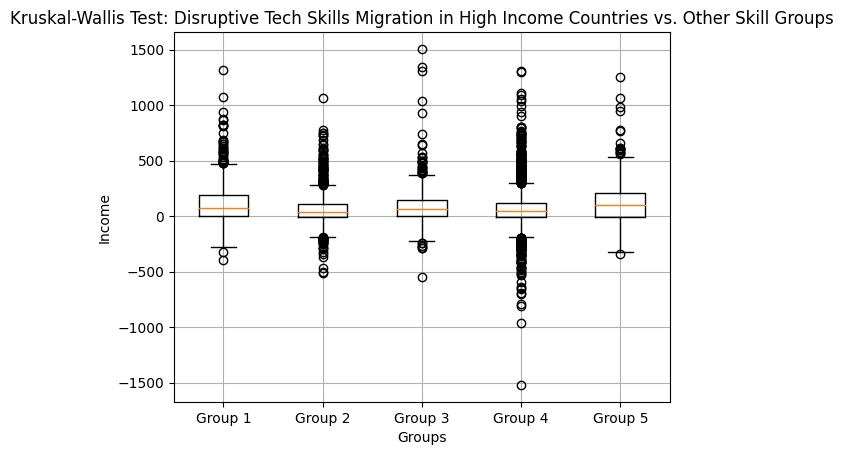

Test statistic: 104.27692680531486
p-value: 1.207708272545294e-21


In [25]:
# NEW (TT)

# We discovered that variance is not equal across all the groups. We cannot use ANOVA because it didn't meet this assumption.
# But we can use other non-parametric analysis like Kruskal-Wallis Test
#
# Kruskal Wallis
# Ref: https://www.youtube.com/watch?v=JJ6RKqRUK10
#
# Disruptive Tech Skills Migration in High Income Countries vs. Other Skill Groups
# Ho: no difference
# Ha: has diffenrece
#
data_group1 = hi_df['ts']['net_per_10k']
data_group2 = hi_df['bs']['net_per_10k']
data_group3 = hi_df['ss']['net_per_10k']
data_group4 = hi_df['sis']['net_per_10k']
data_group5 = hi_df['dts']['net_per_10k']

from scipy import stats

result = stats.kruskal(data_group1, data_group2, data_group3, data_group4, data_group5)

# Create a box plot
plt.boxplot([data_group1, data_group2, data_group3, data_group4, data_group5], labels=['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5'])
plt.title("Kruskal-Wallis Test: Disruptive Tech Skills Migration in High Income Countries vs. Other Skill Groups")
plt.xlabel("Groups")
plt.ylabel("Income")
plt.grid(True)
plt.show()

print("Test statistic:", result.statistic)
print("p-value:", result.pvalue)

# T-Test for each pair of Skill Group

In [26]:
hi_dts_data = hi_df['dts']['net_per_10k']
hi_ts_data = hi_df['ts']['net_per_10k']
hi_bs_data = hi_df['bs']['net_per_10k']
hi_sis_data = hi_df['sis']['net_per_10k']
hi_ss_data = hi_df['ss']['net_per_10k']

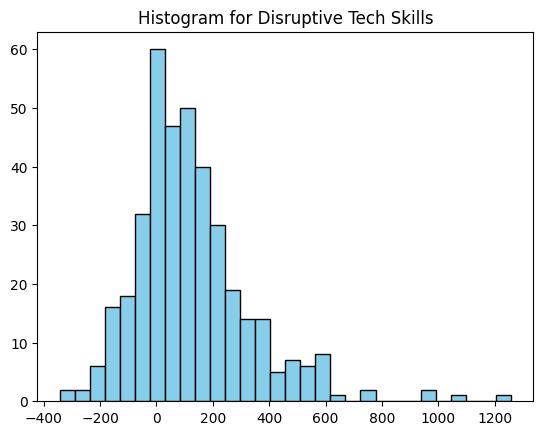

In [27]:
plt.hist(hi_dts_data, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram for Disruptive Tech Skills')
plt.show()

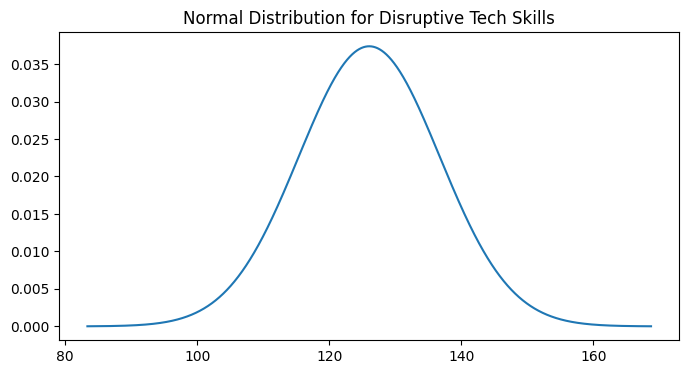

In [28]:
mean = hi_dts_data.mean()
sd = hi_dts_data.std()
population_size = hi_dts_data.count()
se = sd / np.sqrt(population_size)

plt.figure(figsize=(8,4))
x1=np.arange(mean-4*se,mean+4*se,0.01)
y1= stats.norm.pdf(np.arange(mean-4*se,mean+4*se,0.01),loc=mean,scale=se)
plt.title("Normal Distribution for Disruptive Tech Skills")
plt.plot(x1,y1)

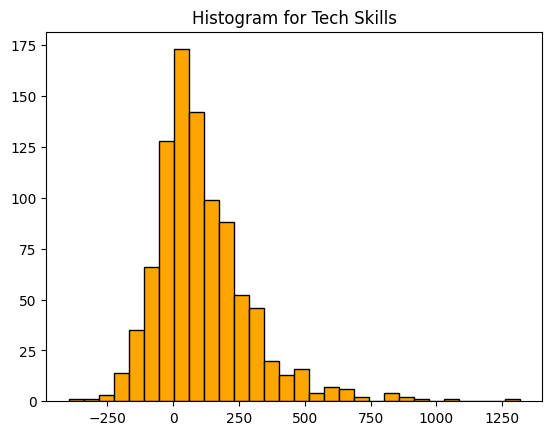

In [29]:
plt.hist(hi_ts_data, bins=30, color='orange', edgecolor='black')
plt.title('Histogram for Tech Skills')
plt.show()

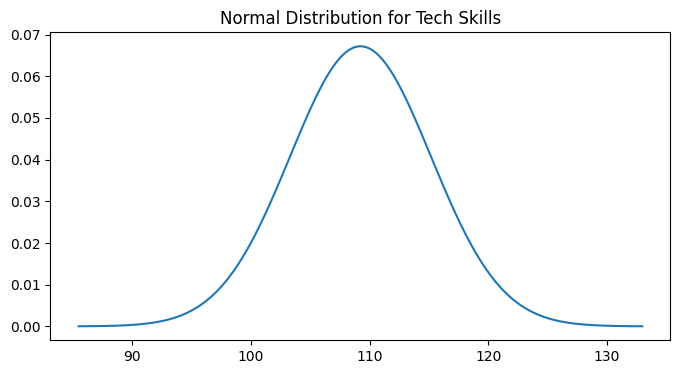

In [30]:
mean = hi_ts_data.mean()
sd = hi_ts_data.std()
population_size = hi_ts_data.count()
se = sd / np.sqrt(population_size)

plt.figure(figsize=(8,4))
x1=np.arange(mean-4*se,mean+4*se,0.01)
y1= stats.norm.pdf(np.arange(mean-4*se,mean+4*se,0.01),loc=mean,scale=se)
plt.title("Normal Distribution for Tech Skills")
plt.plot(x1,y1)

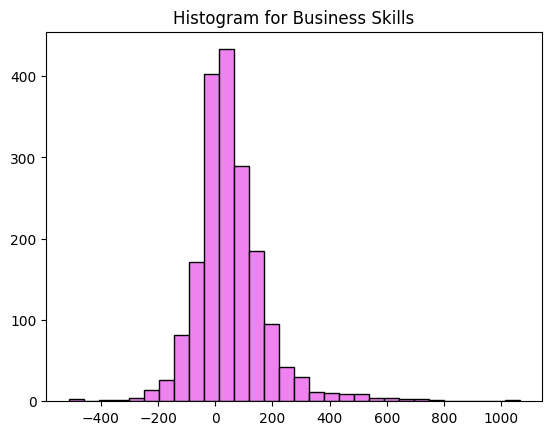

In [31]:
plt.hist(hi_bs_data, bins=30, color='violet', edgecolor='black')
plt.title('Histogram for Business Skills')
plt.show()

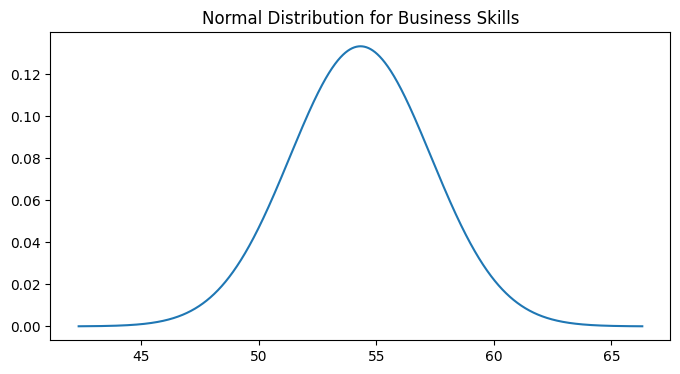

In [32]:
mean = hi_bs_data.mean()
sd = hi_bs_data.std()
population_size = hi_bs_data.count()
se = sd / np.sqrt(population_size)

plt.figure(figsize=(8,4))
x1=np.arange(mean-4*se,mean+4*se,0.01)
y1= stats.norm.pdf(np.arange(mean-4*se,mean+4*se,0.01),loc=mean,scale=se)
plt.title("Normal Distribution for Business Skills")
plt.plot(x1,y1)

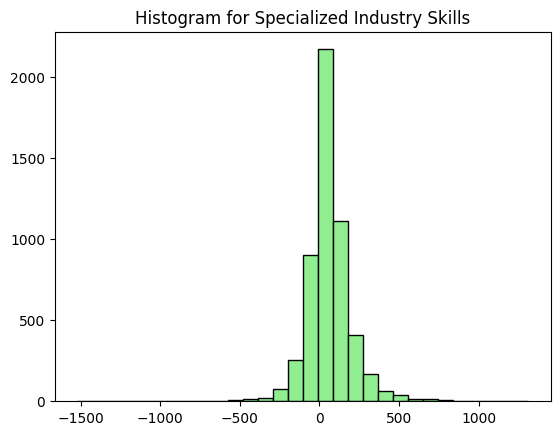

In [33]:
plt.hist(hi_sis_data, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram for Specialized Industry Skills')
plt.show()

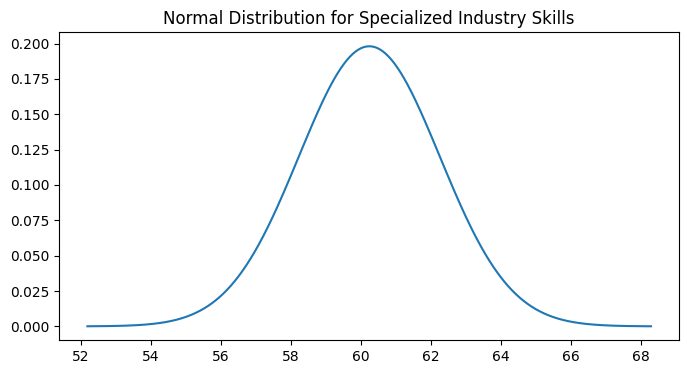

In [34]:
mean = hi_sis_data.mean()
sd = hi_sis_data.std()
population_size = hi_sis_data.count()
se = sd / np.sqrt(population_size)

plt.figure(figsize=(8,4))
x1=np.arange(mean-4*se,mean+4*se,0.01)
y1= stats.norm.pdf(np.arange(mean-4*se,mean+4*se,0.01),loc=mean,scale=se)
plt.title("Normal Distribution for Specialized Industry Skills")
plt.plot(x1,y1)

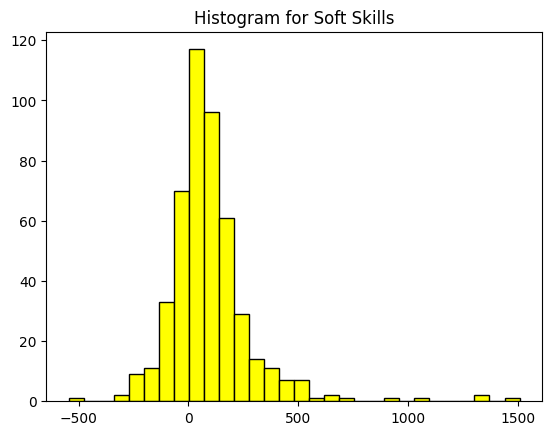

In [35]:
plt.hist(hi_ss_data, bins=30, color='yellow', edgecolor='black')
plt.title('Histogram for Soft Skills')
plt.show()

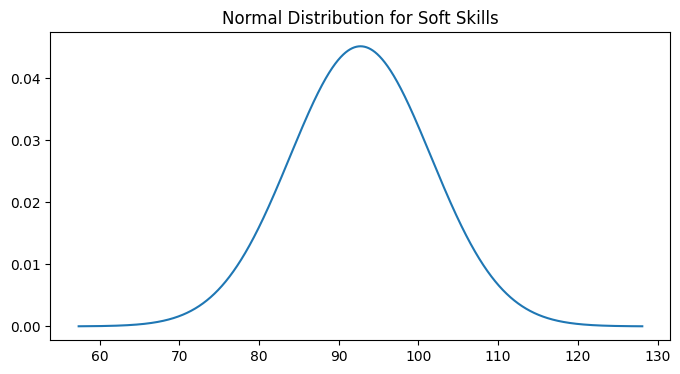

In [36]:
mean = hi_ss_data.mean()
sd = hi_ss_data.std()
population_size = hi_ss_data.count()
se = sd / np.sqrt(population_size)

plt.figure(figsize=(8,4))
x1=np.arange(mean-4*se,mean+4*se,0.01)
y1= stats.norm.pdf(np.arange(mean-4*se,mean+4*se,0.01),loc=mean,scale=se)
plt.title("Normal Distribution for Soft Skills")
plt.plot(x1,y1)

In [37]:
print("Test for homogenity for Disruptive Tech Skills vs Tech Skills")
res=stats.levene(hi_dts_data,hi_ts_data)
pval = res.pvalue
print("pvalue:",{float('{:0.5f}'.format(pval))})

Test for homogenity for Disruptive Tech Skills vs Tech Skills
pvalue: {0.01064}


In [38]:
print("Variance","Disruptive Tech Skills",np.var(hi_dts_data), "Tech Skills",np.var(hi_ts_data))
print("T-test result for Disruptive Tech Skills vs Tech Skills:")
#stats.ttest_ind(hi_dts_data, hi_ts_data)
res= stats.ttest_ind(hi_dts_data, hi_ts_data)
#p_value = np.round(res.pvalue,4)
p_value = res.pvalue
print("Pvalue:",{float('{:0.4f}'.format(p_value))})

Variance Disruptive Tech Skills 43532.65333770903 Tech Skills 32583.505014474802
T-test result for Disruptive Tech Skills vs Tech Skills:
Pvalue: {0.1439}


In [39]:
print("Result of T-test for Disruptive Tech Skills vs Tech Skills:")
if p_value < 0.05:
    print("Null Hypothesis rejected in favour of Alternate Hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is not comparable to Tech Skills")
else:
    print("Fail to reject Null hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is comparable to Tech Skills")

Result of T-test for Disruptive Tech Skills vs Tech Skills:
Fail to reject Null hypothesis
Net per 10K migration in Disruptive Tech Skills is comparable to Tech Skills


In [40]:
print("Test for homogenity for Disruptive Tech Skills vs Business Skills")
res=stats.levene(hi_dts_data,hi_bs_data)
pval = res.pvalue
print("pvalue:",{float('{:0.4e}'.format(pval))})

Test for homogenity for Disruptive Tech Skills vs Business Skills
pvalue: {4.5896e-25}


In [41]:
print("Variance","Disruptive Tech Skills",np.var(hi_dts_data), "Business Skills",np.var(hi_bs_data))
print("T-test result for Disruptive Tech Skills vs Business Skills:")
#stats.ttest_ind(hi_dts_data, hi_bs_data)
res= stats.ttest_ind(hi_dts_data, hi_bs_data)
#p_value = np.round(res.pvalue,4)
p_value = res.pvalue
print("Pvalue:",{float('{:0.4e}'.format(p_value))})

Variance Disruptive Tech Skills 43532.65333770903 Business Skills 16471.31331847996
T-test result for Disruptive Tech Skills vs Business Skills:
Pvalue: {3.2461e-18}


In [42]:
print("Result of T-test for Disruptive Tech Skills vs Business Skills:")
if p_value < 0.05:
    print("Null Hypothesis rejected in favour of Alternate Hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is not comparable to Business Skills")
else:
    print("Fail to reject Null hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is comparable to Business Skills")

Result of T-test for Disruptive Tech Skills vs Business Skills:
Null Hypothesis rejected in favour of Alternate Hypothesis
Net per 10K migration in Disruptive Tech Skills is not comparable to Business Skills


In [43]:
print("Test for homogenity for Disruptive Tech Skills vs Specialized Industry Skills")
res=stats.levene(hi_dts_data,hi_sis_data)
pval = res.pvalue
print("pvalue:",{float('{:0.4e}'.format(pval))})

Test for homogenity for Disruptive Tech Skills vs Specialized Industry Skills
pvalue: {8.7612e-19}


In [44]:
print("Variance","Disruptive Tech Skills",np.var(hi_dts_data), "Specialized Industry Skills",np.var(hi_sis_data))
print("T-test result for Disruptive Tech Skills vs Specialized Industry Skills:")
res= stats.ttest_ind(hi_dts_data, hi_sis_data)
#p_value = np.round(res.pvalue,4)
p_value = res.pvalue
print("Pvalue:",{float('{:0.4e}'.format(p_value))})

Variance Disruptive Tech Skills 43532.65333770903 Specialized Industry Skills 21430.27604857158
T-test result for Disruptive Tech Skills vs Specialized Industry Skills:
Pvalue: {2.655e-16}


In [45]:
print("Result of T-test for Disruptive Tech Skills vs Specialised Industry Skills:")
if p_value < 0.05:
    print("Null Hypothesis rejected in favour of Alternate Hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is not comparable to Specialized Industry Skills")
else:
    print("Fail to reject Null hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is comparable to Specialized Industry Skills")

Result of T-test for Disruptive Tech Skills vs Specialised Industry Skills:
Null Hypothesis rejected in favour of Alternate Hypothesis
Net per 10K migration in Disruptive Tech Skills is not comparable to Specialized Industry Skills


In [46]:
print("Test for homogenity for Disruptive Tech Skills vs Soft Skills")
res=stats.levene(hi_dts_data,hi_ss_data)
pval = res.pvalue
print("pvalue:",{float('{:0.5f}'.format(pval))})

Test for homogenity for Disruptive Tech Skills vs Soft Skills
pvalue: {0.00781}


In [47]:
print("Variance","Disruptive Tech Skills",np.var(hi_dts_data), "Soft Skills",np.var(hi_ss_data))
print("T-test result for Disruptive Tech Skills vs Soft Skills:")
res= stats.ttest_ind(hi_dts_data, hi_ss_data)
#p_value = np.round(res.pvalue,4)
p_value = res.pvalue
print("Pvalue:",{float('{:0.5f}'.format(p_value))})

Variance Disruptive Tech Skills 43532.65333770903 Soft Skills 37203.76488816107
T-test result for Disruptive Tech Skills vs Soft Skills:
Pvalue: {0.01551}


In [48]:
print("Result of T-test for Disruptive Tech Skills vs Soft Skills:")
if p_value < 0.05:
    print("Null Hypothesis rejected in favour of Alternate Hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is not comparable to Soft Skills")
else:
    print("Fail to reject Null hypothesis")
    print("Net per 10K migration in Disruptive Tech Skills is comparable to Soft Skills")

Result of T-test for Disruptive Tech Skills vs Soft Skills:
Null Hypothesis rejected in favour of Alternate Hypothesis
Net per 10K migration in Disruptive Tech Skills is not comparable to Soft Skills


# End of analysis : Use PAIR T TEST for disruptive tech skills only (high income vs low income, high income vs lower middle, high income vs …)

In [49]:
from scipy.stats import ttest_ind
from scipy import stats

hi_dts_data = hi_df['dts']['net_per_10k']
umi_dts_data = umi_df['dts']['net_per_10k']
lmi_dts_data = lmi_df['dts']['net_per_10k']
li_dts_data = li_df['dts']['net_per_10k']

# DATA VISUALIZATION

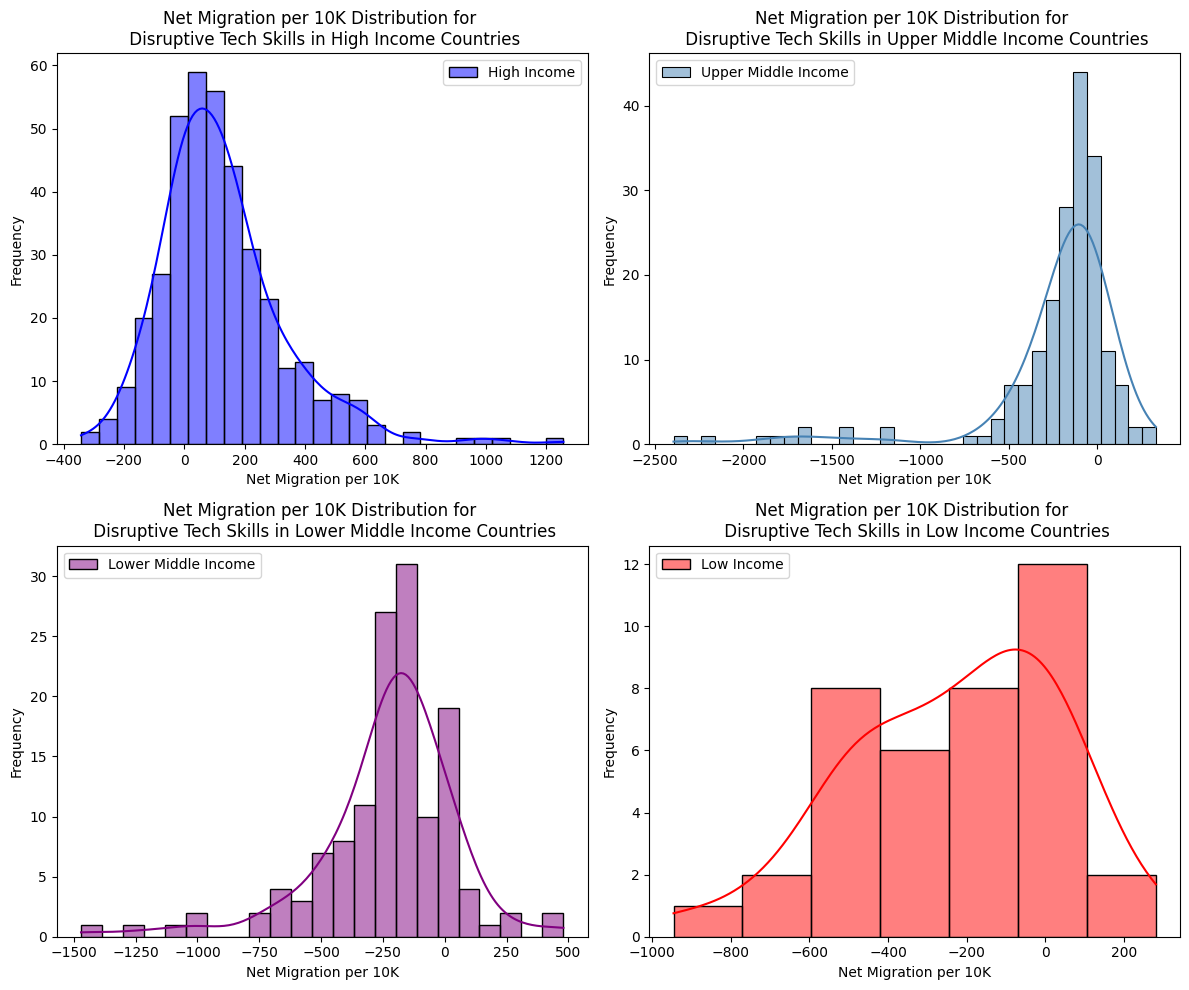

In [50]:
import seaborn as sns
# Histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(hi_dts_data, kde=True, ax=axes[0, 0], color='blue', label='High Income')
sns.histplot(umi_dts_data, kde=True, ax=axes[0, 1], color='steelblue', label='Upper Middle Income')
sns.histplot(lmi_dts_data, kde=True, ax=axes[1, 0], color='purple', label='Lower Middle Income')
sns.histplot(li_dts_data, kde=True, ax=axes[1, 1], color='red', label='Low Income')
axes[0, 0].set_title('Net Migration per 10K Distribution for \n Disruptive Tech Skills in High Income Countries')
axes[0, 1].set_title('Net Migration per 10K Distribution for \n Disruptive Tech Skills in Upper Middle Income Countries')
axes[1, 0].set_title('Net Migration per 10K Distribution for \n Disruptive Tech Skills in Lower Middle Income Countries')
axes[1, 1].set_title('Net Migration per 10K Distribution for \n Disruptive Tech Skills in Low Income Countries')
for ax in axes.flat:
    ax.set_xlabel('Net Migration per 10K')
    ax.set_ylabel('Frequency')
    ax.legend()
plt.tight_layout()
plt.show()

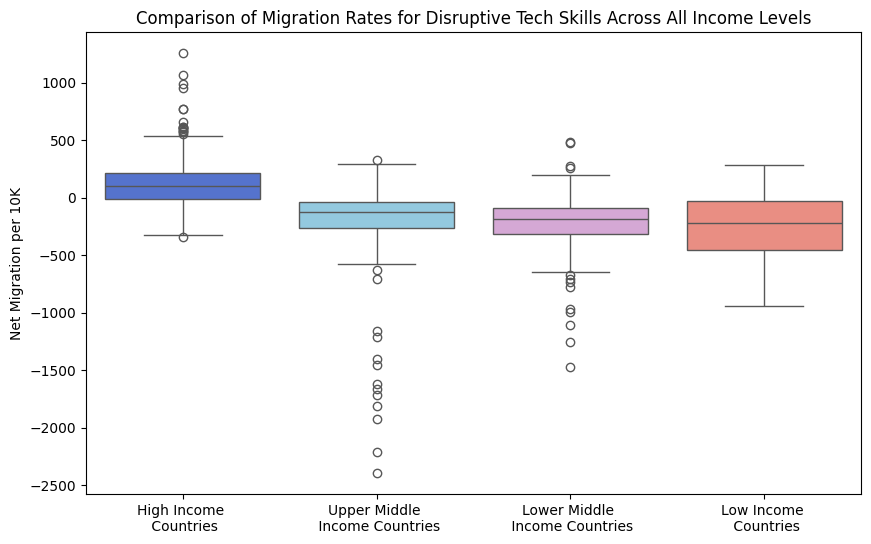

In [51]:
# Boxplot for visual comparison
combined_data = pd.concat([
    hi_dts_data.rename('High Income \n Countries'),
    umi_dts_data.rename('Upper Middle \n Income Countries'),
    lmi_dts_data.rename('Lower Middle \n Income Countries'),
    li_dts_data.rename('Low Income \n Countries')
], axis=1)

color_dict = {
    'High Income \n Countries': 'royalblue',
    'Upper Middle \n Income Countries': 'skyblue',
    'Lower Middle \n Income Countries': 'plum',
    'Low Income \n Countries': 'salmon'
}

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, palette=color_dict)
plt.title('Comparison of Migration Rates for Disruptive Tech Skills Across All Income Levels')
plt.ylabel('Net Migration per 10K')
plt.show()

In [52]:
combined_data.describe()

,High Income \n Countries,Upper Middle \n Income Countries,Lower Middle \n Income Countries,Low Income \n Countries
count,383.000000,186.000000,136.000000,39.000000
mean,126.059034,-231.787688,-231.386985,-231.326154
std,208.917719,411.330997,280.472522,267.956659
min,-342.260000,-2395.310000,-1470.780000,-945.000000
25%,-10.635000,-265.097500,-317.512500,-457.885000
50%,96.670000,-125.245000,-189.940000,-217.520000
75%,209.635000,-40.375000,-93.572500,-32.190000
max,1256.500000,330.410000,479.550000,280.850000


# T-Tests

In [53]:
# Perform the Levene's test for equality of variances for hi_df and umi_df
levene_statistic, p_value = stats.levene(hi_dts_data, umi_dts_data)

print(f"Levene's statistic: {levene_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The variances are unequal, so we want to use Welch's t-test.")
    t_stat, p_value = ttest_ind(hi_dts_data, umi_dts_data, equal_var=False)

    print("\tt-statistic for Welsh's test:", t_stat)
    print(f"\tp-value for Welsh's test: {float('{:0.4e}'.format(p_value))}")
else:
    print("The variances are equal.")


Levene's statistic: 8.165639060032722
p-value: 0.004425887996569046
The variances are unequal, so we want to use Welch's t-test.
	t-statistic for Welsh's test: 11.184891405199572
	p-value for Welsh's test: 1.611e-23


In [54]:
# Perform the Levene's test for equality of variances for hi_df and lmi_df
levene_statistic, p_value = stats.levene(hi_dts_data, lmi_dts_data)

print(f"Levene's statistic: {levene_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The variances are unequal, so we want to use Welch's t-test.")
    t_stat, p_value = ttest_ind(hi_dts_data, lmi_dts_data, equal_var=False)

    print("\tt-statistic for Welsh's test:", t_stat)
    print(f"\tp-value for Welsh's test: {float('{:0.4e}'.format(p_value))}")
else:
    print("The variances are equal.")

Levene's statistic: 4.893681887161244
p-value: 0.027391525947319348
The variances are unequal, so we want to use Welch's t-test.
	t-statistic for Welsh's test: 13.5843517288151
	p-value for Welsh's test: 7.5833e-30


In [55]:
# Perform the Levene's test for equality of variances for hi_df and li_df
levene_statistic, p_value = stats.levene(hi_dts_data, li_dts_data)

print(f"Levene's statistic: {levene_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The variances are unequal, so we want to use Welch's t-test.")
    t_stat, p_value = ttest_ind(hi_dts_data, li_dts_data, equal_var=False)

    print("\tt-statistic for Welsh's test:", t_stat)
    print(f"\tp-value for Welsh's test: {float('{:0.4e}'.format(p_value))}")
else:
    print("The variances are equal.")

Levene's statistic: 7.729418343687018
p-value: 0.005677053914126741
The variances are unequal, so we want to use Welch's t-test.
	t-statistic for Welsh's test: 8.08281402696509
	p-value for Welsh's test: 3.722e-10


Explanation:
- The Levene's test is used to check if the variances of two populations are equal.
- The null hypothesis is that the variances are equal.
- The alternative hypothesis is that the variances are not equal.
- If the p-value is less than 0.05, we reject the null hypothesis and conclude that the variances are not equal.
- If the p-value is greater than or equal to 0.05, we fail to reject the null hypothesis and cannot conclude that the variances are not equal.

For our datasets, the Levene's test for two income groups comparisons (High vs Upper Middle/Lower Middle/Low incomes) concludes that the p-value is less than 0.05,
so we reject the null hypothesis and conclude that the variances are not equal.

Since the variances are not equal, we should use the Welch's t-test, which is a t-test that does not assume equal variances.

Interpretation for Welch's t-test:
- The t-statistic is a measure of the difference between the means of the two groups.
- The p-value is the probability of getting a t-statistic as extreme as the one we observed, assuming that the null hypothesis is true.
- If the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant difference between the means of the two groups.
- If the p-value is greater than or equal to 0.05, we fail to reject the null hypothesis and cannot conclude that there is a significant difference between the means of the two groups.

For our datasets, the p-value is less than 0.05, so we reject the null hypothesis and conclude that there is a significant difference between the means of two groups.
This means that the net migration rate of disruptive tech skills is significantly different between high-income and Upper Middle/Lower Middle/Low income countries.



